<BR>
<img src="./images/misc/optaa_spectra_0_10_20_JAN_2019.png" style="float: left;" alt="drawing" width="1200"/>
<div style="clear: left"><BR>
<BR>
Above: From 2019 Jan 1, 10, 20 OA and BA profiles
    
<BR><BR>
<img src="./images/misc/nitrate_2019_JAN_1_to_10.png" style="float: left;" alt="drawing" width="500"/>
<div style="clear: left"><BR><BR>
Above: From 2019 Jan 1 -- 10: nitrate concentration profiles

on day 31 i.e. doy 31


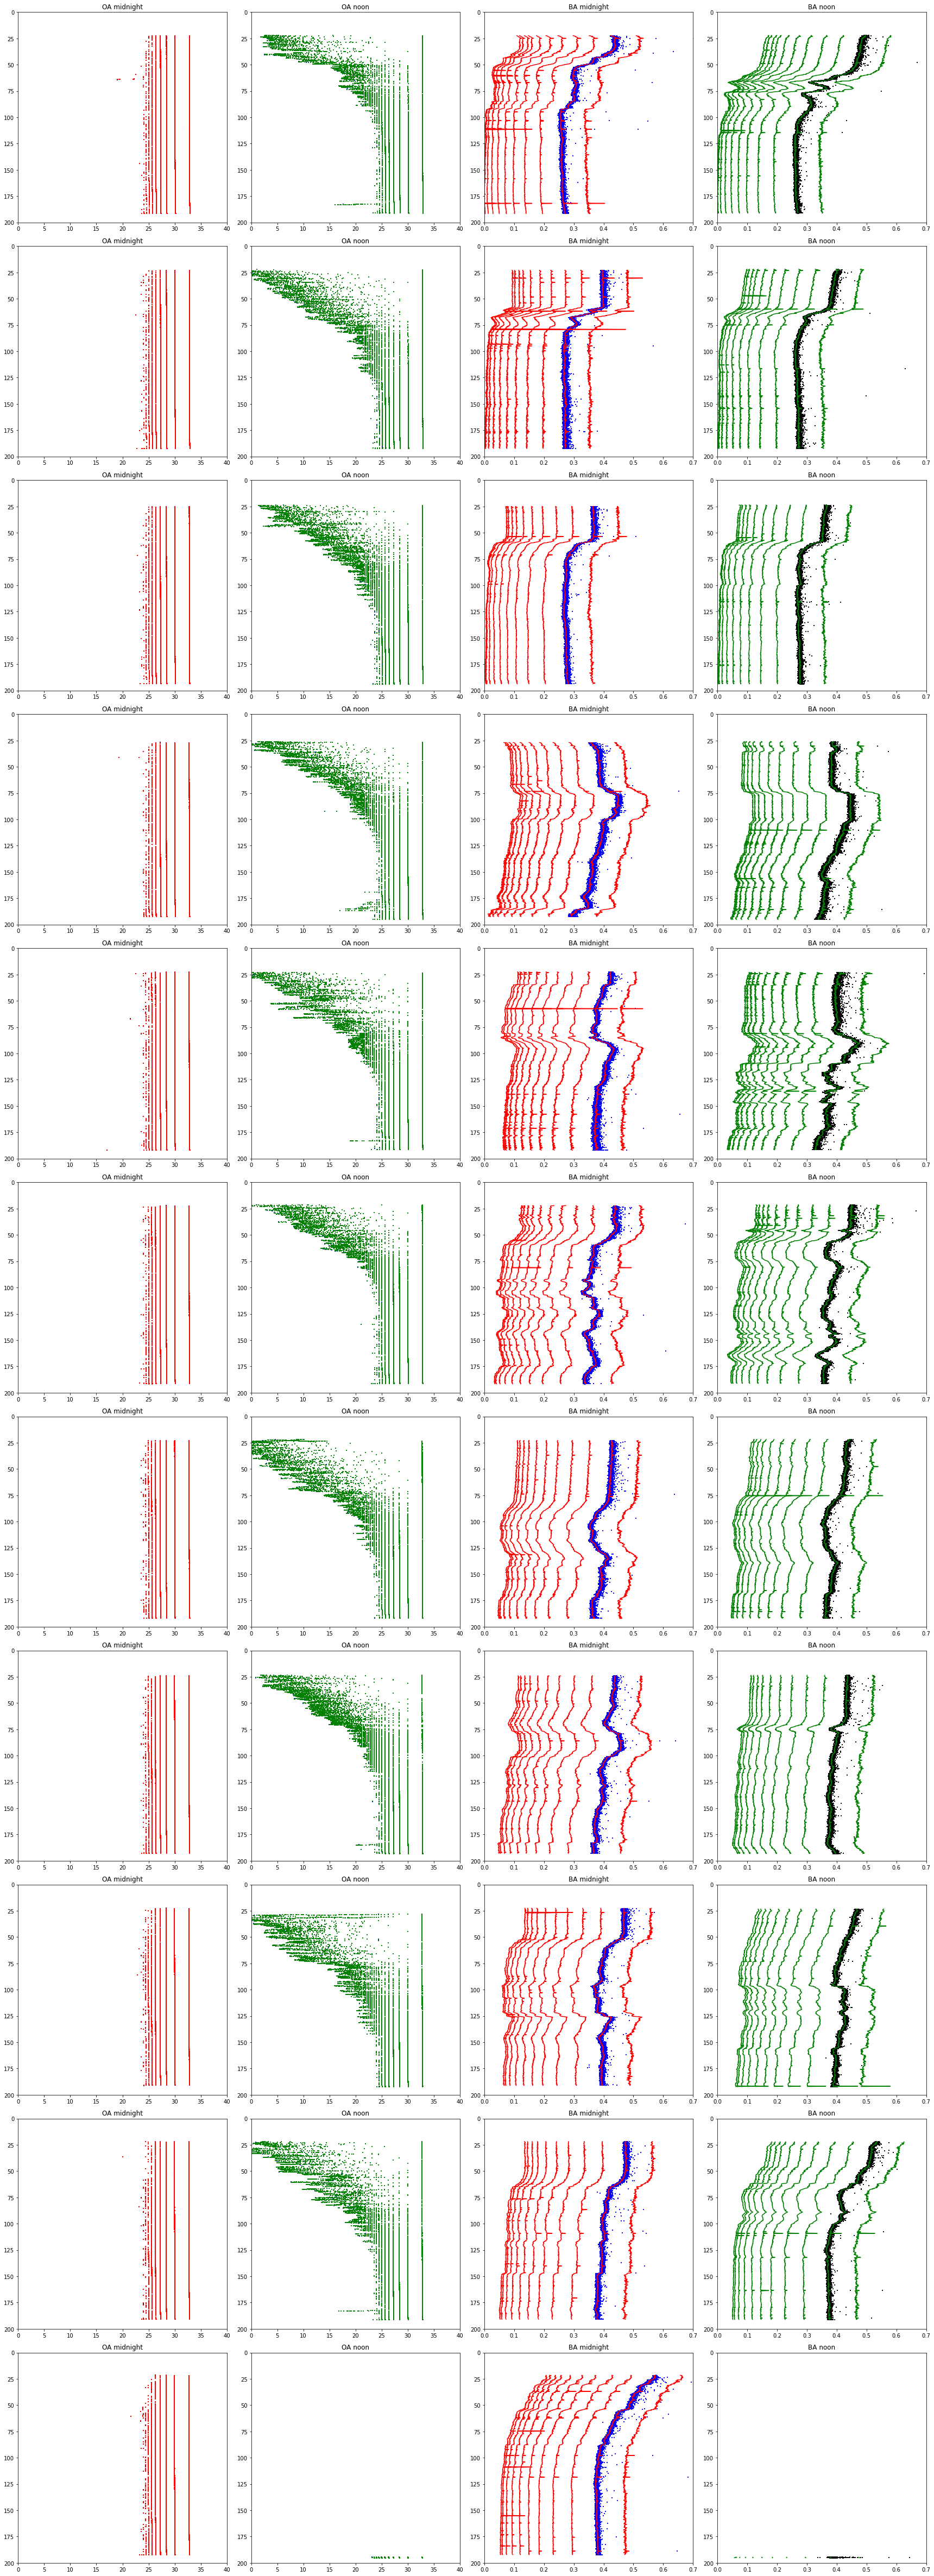

In [3]:
####################
#
# Spectrophotometer
#   OA = Optical Absorbance (deferred owing to pathologies in the data, particularly midnight)
#   BA = Beam Absorbance
#
# This code selects a subset of days and corresponds a number of plot rows, stacked vertically
#   going across you get oa midnight, noon and ba midnight, noon, so 4 across
#
####################

# single data read covers OA and BA, both ascents each day, 2019 JAN - SEP
ds_optaa = xr.open_dataset(data_dir + 'rca/simpler/osb_sp_optaa_2019.nc')

warnings.filterwarnings('ignore')

include_plots = True                    #******************************************************************* control ****

m_strs = ['01', '02', '03', '04', '05', '06', '07', '08', '09']           # relevant 2019 months
m_days = [31, 28, 31, 30, 31, 30, 31, 31, 30]                             # days per month in 2019

month_index = 0                                                           # manage time via months and days; 0 is January
month_str   = m_strs[month_index]  
year_str    = '2019'

n_meters          = 200
n_bins_per_meter  = 4
halfbin           = (1/2) * (1/n_bins_per_meter)
n_pressure_bins   = n_meters * n_bins_per_meter
n_wavelengths     = 86
wavelength        = [i for i in range(n_wavelengths)]
p_bounds          = np.linspace(0., n_meters, n_pressure_bins + 1)             # 801 bounds: 0., .25, ..., 200.                   
pressure          = np.linspace(halfbin, n_meters - halfbin, n_pressure_bins)  # 800 centers: 0.125, ..., 199.875                  
oa_upper_bound    = 40.
ba_upper_bound    = 0.7
wavelength_stride = 8

ndays = m_days[month_index]
ndayplots, dayplotdays = 11, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

l_da_oa_midn, l_da_oa_noon, l_da_ba_midn, l_da_ba_noon = [], [], [], []       # these lists accumulate DataArrays by day

if include_plots:
    fig_height, fig_width, fig_n_across, fig_n_down = 6, 6, 4, ndayplots
    fig, axs = plt.subplots(fig_n_down, fig_n_across, figsize=(fig_width * fig_n_across, fig_height*fig_n_down), tight_layout=True)

# for day_index in range(m_days[month_index]):                                   # loop: days of a chosen month 
for day_index in range(ndays):
    
    day_str  = day_of_month_to_string(day_index + 1); date_str = year_str + '-' + month_str + '-' + day_str
    this_doy = doy(dt64(date_str))
    clear_output(wait = True); print("on day", day_str, 'i.e. doy', this_doy)
    midn_start = date_str + 'T07:00:00'
    midn_done  = date_str + 'T10:00:00'
    noon_start = date_str + 'T20:00:00'
    noon_done  = date_str + 'T23:00:00'

    # pull out OA and BA for both midnight and noon ascents; and swap in pressure for time
    ds_midn = ds_optaa.sel(time=slice(dt64(midn_start), dt64(midn_done))).swap_dims({'time':'int_ctd_pressure'})
    ds_noon = ds_optaa.sel(time=slice(dt64(noon_start), dt64(noon_done))).swap_dims({'time':'int_ctd_pressure'})
    
    da_oa_midn = ds_midn.optical_absorption.expand_dims({'doy':[this_doy]})
    da_oa_noon = ds_noon.optical_absorption.expand_dims({'doy':[this_doy]})
    da_ba_midn = ds_midn.beam_attenuation.expand_dims({'doy':[this_doy]})
    da_ba_noon = ds_noon.beam_attenuation.expand_dims({'doy':[this_doy]})
    
    del da_oa_midn['time']; del da_oa_noon['time']; del da_ba_midn['time']; del da_ba_noon['time']
    
    l_da_oa_midn.append(da_oa_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).min().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_oa_noon.append(da_oa_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).min().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_ba_midn.append(da_ba_midn.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).mean().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    l_da_ba_noon.append(da_ba_noon.sortby('int_ctd_pressure').groupby_bins("int_ctd_pressure", p_bounds, labels=pressure).mean().transpose('wavelength', 'int_ctd_pressure_bins', 'doy'))
    
    if include_plots and day_index in dayplotdays:      # if this is a plotting day: Add to the chart repertoire
        
        dayplotindex = dayplotdays.index(day_index) 
        oa_plot_wavelength = 12
                
        axs[dayplotindex][0].scatter(l_da_oa_midn[-1][oa_plot_wavelength], pressure,  marker=',', s=1, color='k') 
        axs[dayplotindex][1].scatter(l_da_oa_noon[-1][oa_plot_wavelength], pressure,  marker=',', s=1, color='b') 
        axs[dayplotindex][0].set(xlim = (.0, oa_upper_bound), ylim = (200., 0.), title='OA midnight')
        axs[dayplotindex][1].set(xlim = (.0, oa_upper_bound), ylim = (200., 0.), title='OA noon')

        for chan_sel_index in range(2, 83, wavelength_stride):  
            axs[dayplotindex][2].plot(l_da_ba_midn[-1][chan_sel_index], pressure,  marker='', color='r') 
            axs[dayplotindex][3].plot(l_da_ba_noon[-1][chan_sel_index], pressure,  marker='', color='g')
        
        axs[dayplotindex][2].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='BA midnight')
        axs[dayplotindex][3].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='BA noon')

        # Superimpose raw to compare: OA shows quantization; BA shows noise, outliers and suspicious jumps
        axs[dayplotindex][0].scatter(ds_midn.optical_absorption.isel(wavelength=oa_plot_wavelength), ds_midn.int_ctd_pressure, marker=',', s=1., color='r'); 
        axs[dayplotindex][1].scatter(ds_noon.optical_absorption.isel(wavelength=oa_plot_wavelength), ds_noon.int_ctd_pressure, marker=',', s=1., color='g'); 
        axs[dayplotindex][2].scatter(ds_midn.beam_attenuation.isel(wavelength = 2 + wavelength_stride), ds_midn.int_ctd_pressure, marker=',', s=1., color='b'); 
        axs[dayplotindex][3].scatter(ds_noon.beam_attenuation.isel(wavelength = 2 + wavelength_stride), ds_noon.int_ctd_pressure, marker=',', s=1., color='k'); 

save_figure = False                          #******************************************************************* control ****
if save_figure: fig.savefig('/home/ubuntu/savefig.png')

    
########################################
# 
# save resulting datasets for optaa
#
########################################

save_optaa_datasets = False                   #******************************************************************* control ****

if save_optaa_datasets: 

    ds_oa_midn = xr.concat(l_da_oa_midn, dim="doy").to_dataset(name='optical_absorption')
    ds_oa_noon = xr.concat(l_da_oa_noon, dim="doy").to_dataset(name='optical_absorption')
    ds_ba_midn = xr.concat(l_da_ba_midn, dim="doy").to_dataset(name='beam_attenuation')
    ds_ba_noon = xr.concat(l_da_ba_noon, dim="doy").to_dataset(name='beam_attenuation')

    ds_oa_midn.to_netcdf("/data1/optaa/oa_midn_2019_01.nc")
    ds_oa_noon.to_netcdf("/data1/optaa/oa_noon_2019_01.nc")
    ds_ba_midn.to_netcdf("/data1/optaa/ba_midn_2019_01.nc")
    ds_ba_noon.to_netcdf("/data1/optaa/ba_noon_2019_01.nc")

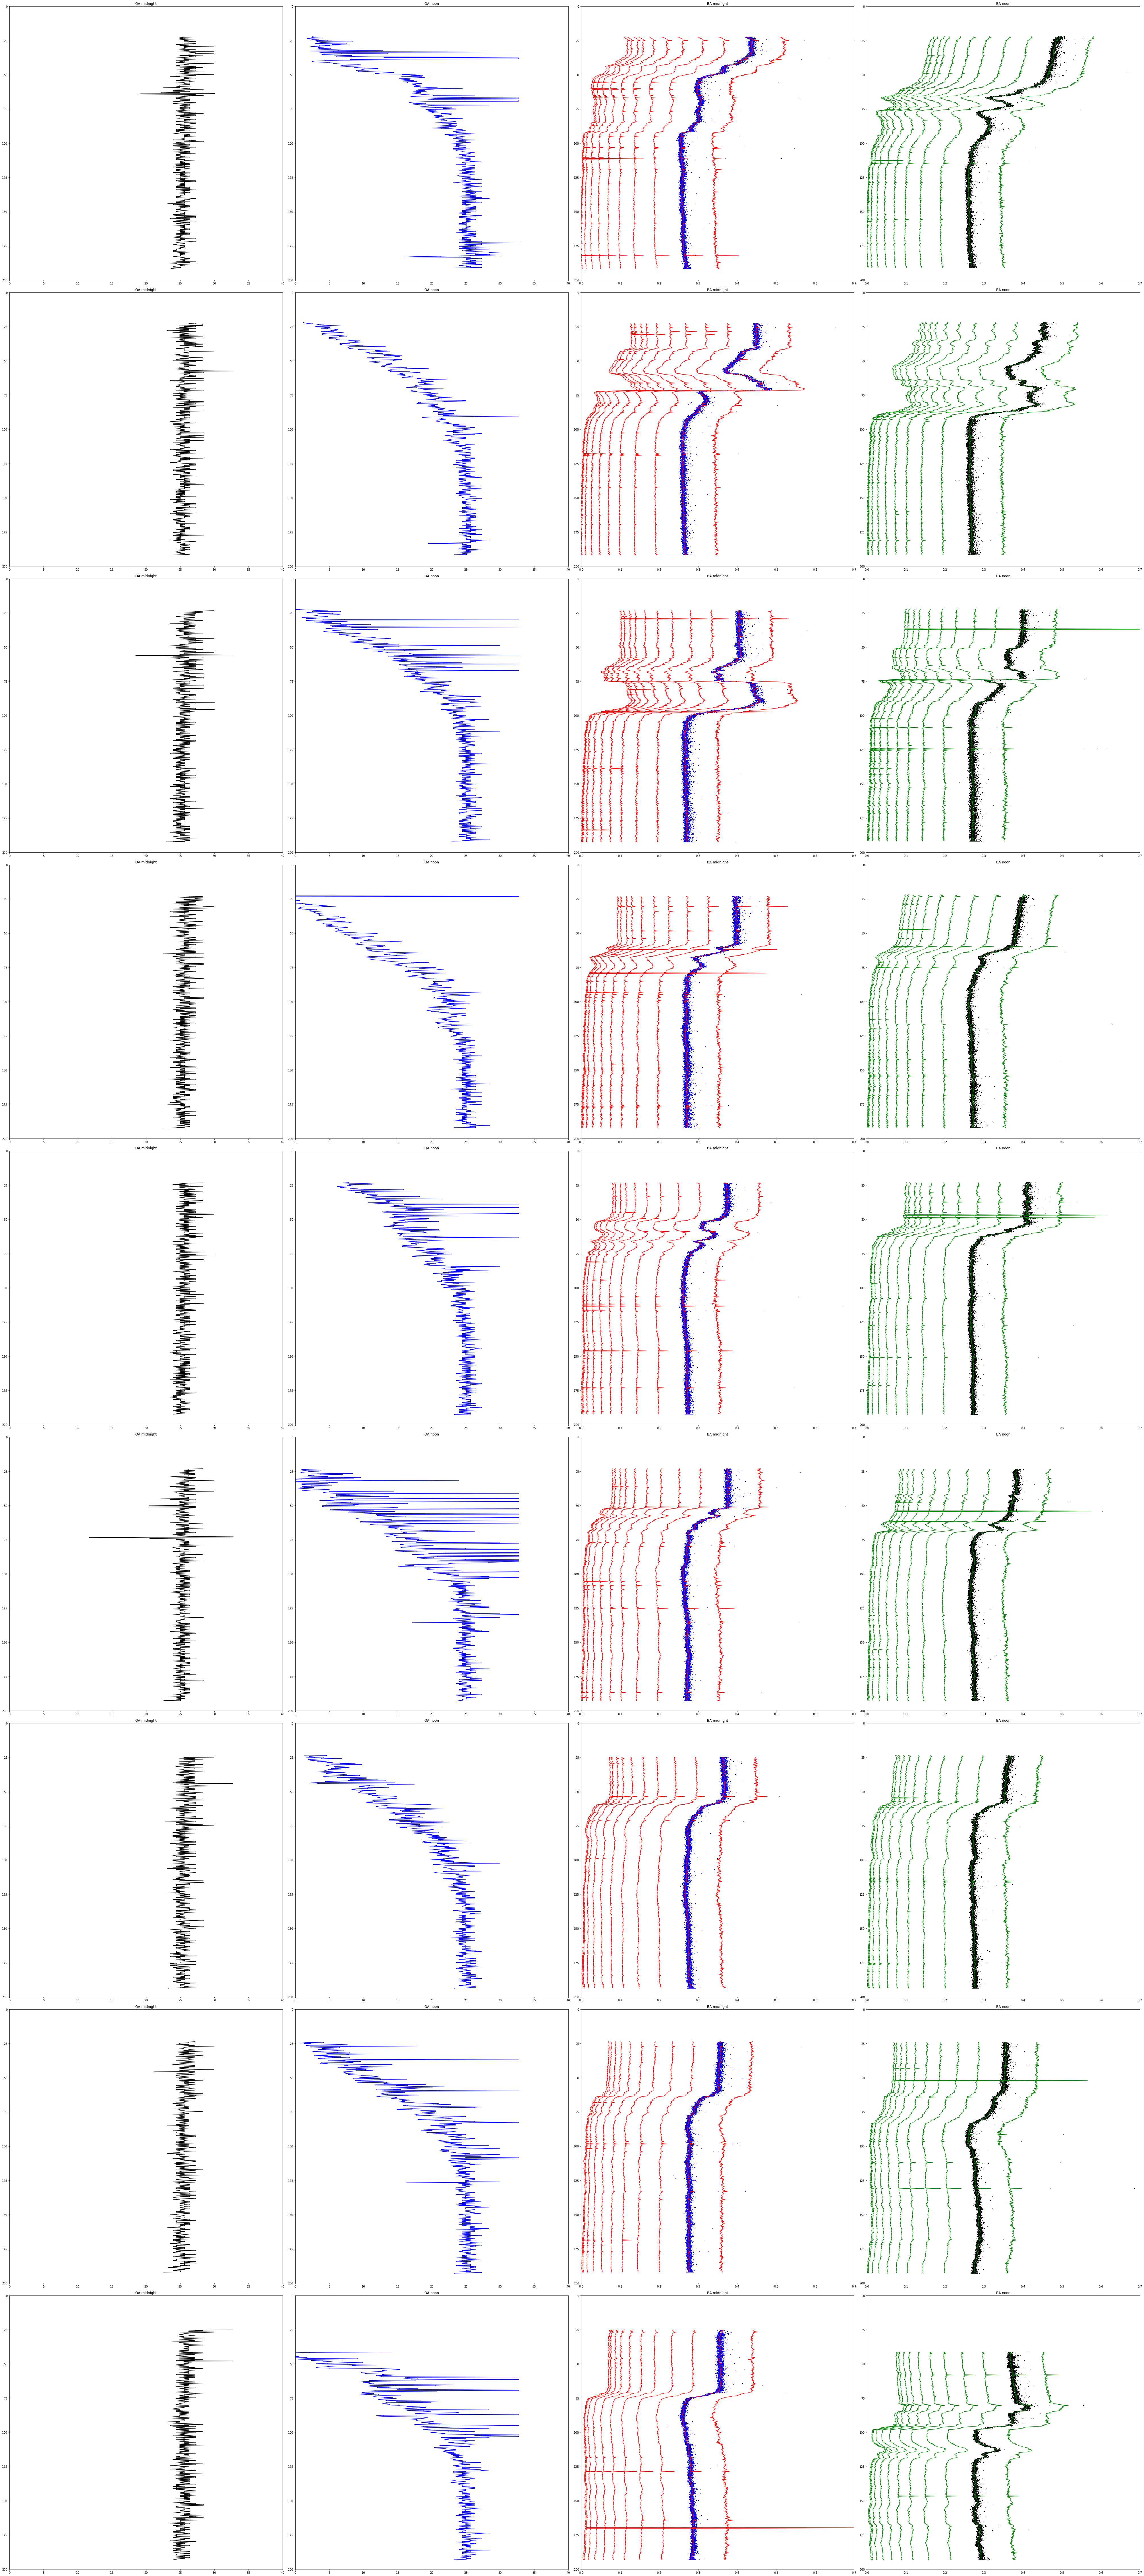

In [4]:
fig_height, fig_width, fig_n_across, fig_n_down = 14, 14, 4, 9
fig, axs = plt.subplots(fig_n_down, fig_n_across, figsize=(fig_width * fig_n_across, fig_height*fig_n_down), tight_layout=True)
for day_index in range(9):

    oa_plot_wavelength = 12
                
    axs[day_index][0].scatter(l_da_oa_midn[day_index][oa_plot_wavelength], pressure,  marker=',', s=1, color='k') 
    axs[day_index][1].scatter(l_da_oa_noon[day_index][oa_plot_wavelength], pressure,  marker=',', s=1, color='b') 
    axs[day_index][0].plot(l_da_oa_midn[day_index][oa_plot_wavelength], pressure,  marker=',', markersize=1, color='k') 
    axs[day_index][1].plot(l_da_oa_noon[day_index][oa_plot_wavelength], pressure,  marker=',', markersize=1, color='b') 

    axs[day_index][0].set(xlim = (.0, 40.), ylim = (200., 0.), title='OA midnight')
    axs[day_index][1].set(xlim = (.0, 40.), ylim = (200., 0.), title='OA noon')

    for chan_sel_index in range(2, 83, wavelength_stride):
            
        axs[day_index][2].plot(l_da_ba_midn[day_index][chan_sel_index], pressure,  marker='', color='r') 
        axs[day_index][3].plot(l_da_ba_noon[day_index][chan_sel_index], pressure,  marker='', color='g')
        axs[day_index][2].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='BA midnight')
        axs[day_index][3].set(xlim = (.0, ba_upper_bound), ylim = (200., 0.), title='BA noon')

    ds_midn = ds_optaa.sel(time=slice(dt64('2019-01-0' + str(day_index+1) + 'T07:00:00'), dt64('2019-01-0' + str(day_index+1) + 'T10:00:00'))).swap_dims({'time':'int_ctd_pressure'})
    ds_noon = ds_optaa.sel(time=slice(dt64('2019-01-0' + str(day_index+1) + 'T20:00:00'), dt64('2019-01-0' + str(day_index+1) + 'T23:00:00'))).swap_dims({'time':'int_ctd_pressure'})

    # Superimpose raw to compare: OA shows quantization; BA shows noise, outliers and suspicious jumps
    # axs[day_index][0].scatter(ds_midn.optical_absorption.isel(wavelength=oa_plot_wavelength), ds_midn.int_ctd_pressure, marker=',', s=1., color='r'); 
    # axs[day_index][1].scatter(ds_noon.optical_absorption.isel(wavelength=oa_plot_wavelength), ds_noon.int_ctd_pressure, marker=',', s=1., color='g'); 
    axs[day_index][2].scatter(ds_midn.beam_attenuation.isel(wavelength = 2 + wavelength_stride), ds_midn.int_ctd_pressure, marker=',', s=1., color='b'); 
    axs[day_index][3].scatter(ds_noon.beam_attenuation.isel(wavelength = 2 + wavelength_stride), ds_noon.int_ctd_pressure, marker=',', s=1., color='k'); 

## Examine selected mean / standard deviation noon profiles

In [ ]:
%%time

nplots = 20

p,a = plt.subplots(nplots, 1, figsize=(16,nplots*8))

a[0].set(ylim = (200., 0.), title='depth(time)')
a[2].set(ylim = (35., 29.), title='salinity(time)')
a[4].set(ylim = (200., 0.), xlim = ( 0.0006, 0.00065), title='SSC(depth)')
a[6].set(ylim = (200., 0.), xlim = (29.    , 35.    ), title='salinity(depth)')
a[8].set(ylim = (200., 0.), xlim = ( 6.    , 20.    ), title='temperature(depth)')
a[10].set(ylim = (200., 0.), xlim = (60.    , 320.   ), title='dissolved oxygen(depth)')
a[12].set(ylim = (200., 0.), xlim = ( 0.    , 3.     ), title='chlorophyll(depth)')
a[14].set(ylim = (200., 0.), xlim = ( 0.5   , 2.5    ), title='cdom(depth)')
a[16].set(ylim = (200., 0.), xlim = ( 0.0   , 0.0005 ), title='TVSC(depth)')
a[18].set(ylim = (200., 0.), xlim = ( 0.0   , 0.003  ), title='optical backscatter(depth)')

a[1].set( ylim = (  3., 0.),                                title='std depth(time)')
a[3].set( ylim = (  3., 0.),                                title='std salinity(time)')
a[5].set( ylim = (200., 0.), xlim = ( 0.0    ,  0.0000015), title='std SSC(depth)')
a[7].set( ylim = (200., 0.), xlim = ( 0.0    ,  0.25     ), title='std salinity(depth)')
a[9].set( ylim = (200., 0.), xlim = ( 0.0    ,  1.0      ), title='std temperature(depth)')
a[11].set(ylim = (200., 0.), xlim = ( 0.0    , 15.       ), title='std dissolved oxygen(depth)')
a[13].set(ylim = (200., 0.), xlim = ( 0.0    ,  1.5      ), title='std chlorophyll(depth)')
a[15].set(ylim = (200., 0.), xlim = ( 0.0    , .50       ), title='std cdom(depth)')
a[17].set(ylim = (200., 0.), xlim = ( 0.0    , 0.001     ), title='std TVSC(depth)')
a[19].set(ylim = (200., 0.), xlim = ( 0.0    , 0.01      ), title='std optical backscatter(depth)')

for monthstring in ['01', '02', '03', '04', '05', '06', '07', '08', '09']:
    for daystring in ['01', '15']:
        datestring0 = '2019-' + monthstring + '-' + daystring + 'T08:30' 
        datestring1 = '2019-' + monthstring + '-' + daystring + 'T11:50' 
        ds1 = ds_mean.sel(time=slice(datestring0, datestring1))
        a[0].plot(ds1.time.values, ds1.seawater_pressure)
        a[2].plot(ds1.time.values, ds1.practical_salinity)
        a[4].plot(ds1.seawater_scattering_coefficient, ds1.seawater_pressure)
        a[6].plot(ds1.practical_salinity, ds1.seawater_pressure)
        a[8].plot(ds1.seawater_temperature, ds1.seawater_pressure)
        a[10].plot(ds1.corrected_dissolved_oxygen, ds1.seawater_pressure)
        a[12].plot(ds1.fluorometric_chlorophyll_a, ds1.seawater_pressure)
        a[14].plot(ds1.fluorometric_cdom, ds1.seawater_pressure)
        a[16].plot(ds1.total_volume_scattering_coefficient, ds1.seawater_pressure)
        a[18].plot(ds1.optical_backscatter, ds1.seawater_pressure)
        
        ds2 = ds_std.sel(time=slice(datestring0, datestring1))
        a[1].plot(ds2.time.values, ds2.seawater_pressure)
        a[3].plot(ds2.time.values, ds2.practical_salinity)
        a[5].plot(ds2.seawater_scattering_coefficient, ds1.seawater_pressure)
        a[7].plot(ds2.practical_salinity, ds1.seawater_pressure)
        a[9].plot(ds2.seawater_temperature, ds1.seawater_pressure)
        a[11].plot(ds2.corrected_dissolved_oxygen, ds1.seawater_pressure)
        a[13].plot(ds2.fluorometric_chlorophyll_a, ds1.seawater_pressure)
        a[15].plot(ds2.fluorometric_cdom, ds1.seawater_pressure)
        a[17].plot(ds2.total_volume_scattering_coefficient, ds1.seawater_pressure)
        a[19].plot(ds2.optical_backscatter, ds1.seawater_pressure)
        
        

In [ ]:
%%time

nplots = 12
p,a = plt.subplots(12, 1, figsize=(10,nplots*6))

lim_salinity_lo,    lim_salinity_hi    = 29.5, 34.5
lim_temperature_lo, lim_temperature_hi =  6.,  20.
lim_do_lo,          lim_do_hi          =  0.,  100.
lim_chlor_lo,       lim_chlor_hi       = -0.2,  1.5
lim_cdom_lo,        lim_cdom_hi        =  0.,   1.8
lim_backscatt_lo,   lim_backscatt_hi   =  0.,   0.004

a[10].scatter(ds1.time,             ds.salinity,                                     color='b',               marker='o', s=36.)
a[11].scatter(time,             sample_count,                              color='r',               marker='o', s=36.)

a[0].set(ylim = (250., 0.), xlim = (lim_salinity_lo, lim_salinity_hi),               title='salinity distribution with depth')
a[1].set(ylim = (250., 0.), xlim = (lim_temperature_lo, lim_temperature_hi),         title='temperature distribution with depth')
a[2].set(ylim = (250., 0.), xlim = (lim_chlor_lo, lim_chlor_hi),                     title='chlorophyll distribution with depth')
a[3].set(ylim = (250., 0.), xlim = (lim_cdom_lo, lim_cdom_hi),                       title='cdom distribution with depth')
a[4].set(ylim = (250., 0.), xlim = (lim_backscatt_lo, lim_backscatt_hi),             title='backscatter distribution with depth')
a[5].set(ylim = (lim_salinity_lo, lim_salinity_hi),                                  title='salinity distribution with time')
a[6].set(ylim = (lim_temperature_lo, lim_temperature_hi),                            title='temperature distribution with time')
a[7].set(ylim = (lim_chlor_lo, lim_chlor_hi),                                        title='chlorophyll distribution with time')
a[8].set(ylim = (lim_cdom_lo, lim_cdom_hi),                                          title='cdom distribution with time')
a[9].set(ylim = (lim_backscatt_lo, lim_backscatt_hi),                                title='backscatter distribution with time')
a[10].set(ylim=(250., 0.), xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')), title='Distribution of depths with time')
a[11].set(xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')),                  title='Distribution of sample counts with time')

# a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')

In [ ]:
%%time

# Was 10 minutes at full resolution prior to resample


t0 = dt64('2019-05-01T00:00')                
t1 = dt64('2019-09-28T00:00')

nPlots = 8
plt.rcParams.update({'font.size': 10})
p,a = plt.subplots(nPlots, 1, figsize=(18, 5*nPlots))

nTemp = mplcolors.Normalize(vmin=8.,vmax=14.)
nChlor = mplcolors.Normalize(vmin=0.3,vmax=0.8)
nSal = mplcolors.Normalize(vmin=32,vmax=34)
nCDO = mplcolors.Normalize(vmin=100,vmax=250)
nCdom = mplcolors.Normalize(vmin=1.0,vmax=2.0)
nTVSC = mplcolors.Normalize(vmin=0.00008,vmax=0.00035)
nSSC = mplcolors.Normalize(vmin=0.00062,vmax=0.00064)
nBack = mplcolors.Normalize(vmin=0.0005,vmax=0.0020)

swp = ds_mean.seawater_pressure


# ['thermal', 'haline', 'solar', 'ice', 'gray', 'oxy', 'deep', 'dense', 'algae', 'matter', 'turbid',
#  'speed', 'amp', 'tempo', 'rain', 'phase', 'topo', 'balance', 'delta', 'curl', 'diff', 'tarn']

a[0].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.thermal, c=ds_mean.seawater_temperature,                marker= ',', s = 9.0, norm=nTemp)
a[1].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.algae,   c=ds_mean.fluorometric_chlorophyll_a,          marker= ',', s = 9.0, norm=nChlor)
a[2].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.haline,  c=ds_mean.practical_salinity,                  marker= ',', s = 9.0, norm=nSal)
a[3].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.oxy,     c=ds_mean.corrected_dissolved_oxygen,          marker= ',', s = 9.0, norm=nCDO)
a[4].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.matter,  c=ds_mean.fluorometric_cdom,                   marker= ',', s = 9.0, norm=nCdom)
a[5].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.ice,     c=ds_mean.total_volume_scattering_coefficient, marker= ',', s = 9.0, norm=nTVSC)
a[6].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.solar,   c=ds_mean.seawater_scattering_coefficient,     marker= ',', s = 9.0, norm=nSSC)
a[7].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.delta,   c=ds_mean.optical_backscatter,                 marker= ',', s = 9.0, norm=nBack)

for i in range(nPlots):
    a[i].set(ylim=(100., 0.0), xlim = (t0, t1))

a[0].set(title='temperature')
a[1].set(title='chlorophyll')
a[2].set(title='salinity')
a[3].set(title='dissolved oxygen')
a[4].set(title='CDOM')
a[5].set(title='TVSC')
a[6].set(title='SSC')
a[7].set(title='backscatter')

## Re-writing Curtain Plotter as a function (WIP)

In [ ]:
# %%time

# Also include colorbars!

for key in ds.data_vars: 
    if key not in keep_data_vars: ds = ds.drop(key)

def curtains(timerange, ds, norms, depth, cmaps, skip):
    nPlots = len(ds.data_vars) - len(skip)
    for key in ds.data_vars: 
        if key not in skip:
            


t0 = dt64('2019-05-01T00:00')                
t1 = dt64('2019-09-28T00:00')

nPlots = 8
plt.rcParams.update({'font.size': 10})
p,a = plt.subplots(nPlots, 1, figsize=(18, 5*nPlots))

nTemp = mplcolors.Normalize(vmin=8.,vmax=14.)
nChlor = mplcolors.Normalize(vmin=0.3,vmax=0.8)
nSal = mplcolors.Normalize(vmin=32,vmax=34)
nCDO = mplcolors.Normalize(vmin=100,vmax=250)
nCdom = mplcolors.Normalize(vmin=1.0,vmax=2.0)
nTVSC = mplcolors.Normalize(vmin=0.00008,vmax=0.00035)
nSSC = mplcolors.Normalize(vmin=0.00062,vmax=0.00064)
nBack = mplcolors.Normalize(vmin=0.0005,vmax=0.0020)

swp = ds_mean.seawater_pressure


# ['thermal', 'haline', 'solar', 'ice', 'gray', 'oxy', 'deep', 'dense', 'algae', 'matter', 'turbid',
#  'speed', 'amp', 'tempo', 'rain', 'phase', 'topo', 'balance', 'delta', 'curl', 'diff', 'tarn']

a[0].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.thermal, c=ds_mean.seawater_temperature,                marker= ',', s = 9.0, norm=nTemp)
a[1].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.algae,   c=ds_mean.fluorometric_chlorophyll_a,          marker= ',', s = 9.0, norm=nChlor)
a[2].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.haline,  c=ds_mean.practical_salinity,                  marker= ',', s = 9.0, norm=nSal)
a[3].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.oxy,     c=ds_mean.corrected_dissolved_oxygen,          marker= ',', s = 9.0, norm=nCDO)
a[4].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.matter,  c=ds_mean.fluorometric_cdom,                   marker= ',', s = 9.0, norm=nCdom)
a[5].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.ice,     c=ds_mean.total_volume_scattering_coefficient, marker= ',', s = 9.0, norm=nTVSC)
a[6].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.solar,   c=ds_mean.seawater_scattering_coefficient,     marker= ',', s = 9.0, norm=nSSC)
a[7].scatter(ds_mean.time.values, swp, cmap=cmocean.cm.delta,   c=ds_mean.optical_backscatter,                 marker= ',', s = 9.0, norm=nBack)

for i in range(nPlots):
    a[i].set(ylim=(100., 0.0), xlim = (t0, t1))

a[0].set(title='temperature')
a[1].set(title='chlorophyll')
a[2].set(title='salinity')
a[3].set(title='dissolved oxygen')
a[4].set(title='CDOM')
a[5].set(title='TVSC')
a[6].set(title='SSC')
a[7].set(title='backscatter')

## Colorbars 

In [ ]:
%%time

# Was 10 minutes at full resolution prior to resample

# ['thermal', 'haline', 'solar', 'ice', ...]


t0 = dt64('2019-01-01T00:00')                
t1 = dt64('2019-04-01T00:00')

nPlots = 2
plt.rcParams.update({'font.size': 10})

norm_temp = mplcolors.Normalize(vmin=8.,vmax=12.)
norm_chlor = mplcolors.Normalize(vmin=0.3,vmax=0.8)

p,a=plt.subplots(nPlots, 1, figsize=(18,5*nPlots))

im0 = a[0].scatter(ds_mean.time.values, ds_mean.seawater_pressure, cmap=cmocean.cm.thermal, c=ds_mean.seawater_temperature, \
             marker= ',', s = 9.0, norm=norm_temp)
im1 = a[1].scatter(ds_mean.time.values, ds_mean.seawater_pressure, cmap=cmocean.cm.haline, c=ds_mean.fluorometric_chlorophyll_a, \
             marker= ',', s = 9.0, norm=norm_chlor)

a[0].set(ylim=(100., 0.0), xlim = (t0, t1), title='temperature')
a[1].set(ylim=(100., 0.0), xlim = (t0, t1), title='chlorophyll')


cax0 = p.add_axes([0.60, 0.904, 0.26, 0.015])
cax1 = p.add_axes([0.60, 0.492, 0.26, 0.015])
p.colorbar(im0, cax=cax0, orientation='horizontal')
p.colorbar(im1, cax=cax1, orientation='horizontal')

## Oregon Slope Base Shallow Profiler near-surface comparison to MODIS

The Oregon Slope Base site has a depth of about 2900 meters and is located at the base of the continental shelf 
west of Oregon. The fluorometer data are collected over the course of a day as nine profile runs from a depth
of 200 meters to near the surface. Between profiles that profiler pod is at rest on a platform that is always
at a depth of 200 meters. The sampling rate is a little less than on sample per second. 


The objective in this section is to create an approximate record of near-surface chlorophyll (all measurements 
above say 25 meter depth) and compare that with the MODIS values for the same site. 

In [ ]:
ds_flort.dims

## Conversion: doy from datetime64 and datetime64 from (year + doy)

In [ ]:
print('As dates: The 2019 data has start:', ds_mean.time[0].values, 'to end:', ds_mean.time[-1].values)
      
      
# Note use of .values to get the actual datetime64 from the time coordinate
doy0 = doy(ds_mean.time[0].values)
doy1 = doy(ds_mean.time[-1].values)
print('\nThis dataset runs from day', doy0, 'to day', doy1, 'for a span in days of', doy1 - doy0 + 1)

# Make sure 1-JAN works out properly in the other direction
print("\nThe date corresponding to 2019 doy = 1 is", dt64_from_doy(2019, 1))

inter_sample_time = (ds_mean.time[1].values - ds_mean.time[0].values)/td64(1, 's')
print('\nThe time between one-minute (resampled) timestamps is of course', inter_sample_time, 'seconds.')

## Early work on SP Fluorometer data reduction (summer 2019 only)

***Hey seriously look at salinity and picture a chart of the second derivative of a filtered version. That chart will cross zero twice and the zero crossings could be seen as a characterization of the upper layer.***

In [ ]:
###########################
# 
# Shallow profiler data reduction
# 
# From time series we would like to progress to time-block values, for example considering six-day
#   blocks of time throughout the year. There are three criteria for creating a value for some 
#   sensor parameter such as chlorophyll-a: There are samples in a depth range and in a time range;
#   and the mean of these values is substantial when compared to their standard deviation.

# operate on rca_ds_chlor to extract values for a year: Average by week and depth
doy = 164                 # one would eventually make this 0
doy_end = 257             # one would eventually make this 365
year = 2019
depth_start, depth_end, depth_delta = 0., 260.1, 10.
time_interval_days = 1     # even makes the "center of interval" simpler

time = []
depth = []
sample_count = []
salinity = []
temperature = []
chlor = []
cdom = []
backscatt = []

lim_temperature_ignore = 2.0
lim_salinity_ignore    = 1.0
lim_chlor_ignore       = 0.6
lim_cdom_ignore        = 0.8
lim_backscatt_ignore   = 0.0015

while doy < doy_end:
    
    print('day of year', doy)

    time_range_start = dt64(str(year) + '-01-01') + td64(doy, 'D')
    time_range_end   = dt64(str(year) + '-01-01') + td64(doy + time_interval_days, 'D')    
    this_time        = dt64(str(year) + '-01-01') + td64(doy + time_interval_days//2, 'D')
    
    ds1 = rca_ds_chlor.sel(time = slice(time_range_start, time_range_end))
    
    for d in np.arange(depth_start, depth_end, depth_delta): 
        
        this_depth = d + depth_delta/2.
        
        ds2 = ds1.where(ds1.int_ctd_pressure <  d + depth_delta, drop=True)
        ds3 = ds2.where(ds2.int_ctd_pressure >= d,               drop=True)

        nSamples = ds3.dims['time']
        sample_count.append(nSamples)     
        depth.append(this_depth)
        time.append(this_time)  
            
        if nSamples > 1:
   
            param_mean = ds3.practical_salinity.values.mean()
            param_std = ds3.practical_salinity.values.std()
            if param_std < lim_salinity_ignore: salinity.append((param_mean, param_std, this_depth, this_time, nSamples))
                
            param_mean = ds3.seawater_temperature.values.mean()
            param_std = ds3.seawater_temperature.values.std()
            if param_std < lim_temperature_ignore: temperature.append((param_mean, param_std, this_depth, this_time, nSamples))

            param_mean = ds3.fluorometric_chlorophyll_a.values.mean()
            param_std = ds3.fluorometric_chlorophyll_a.values.std()
            if param_std < lim_chlor_ignore: chlor.append((param_mean, param_std, this_depth, this_time, nSamples))
                
            param_mean = ds3.fluorometric_cdom.values.mean()
            param_std = ds3.fluorometric_cdom.values.std()
            if param_std < lim_cdom_ignore: cdom.append((param_mean, param_std, this_depth, this_time, nSamples))

            param_mean = ds3.optical_backscatter.values.mean()
            param_std = ds3.optical_backscatter.values.std()
            if param_std < lim_backscatt_ignore: backscatt.append((param_mean, param_std, this_depth, this_time, nSamples))
        
        else:
            salinity.append((np.nan, np.nan, this_depth, this_time))
            temperature.append((np.nan, np.nan, this_depth, this_time))
            chlor.append((np.nan, np.nan, this_depth, this_time))
            cdom.append((np.nan, np.nan, this_depth, this_time))
            backscatt.append((np.nan, np.nan, this_depth, this_time))

    # increment the day of year by one week
    doy += time_interval_days

In [ ]:
%%time

nplots = 12
p,a = plt.subplots(12, 1, figsize=(10,nplots*6))

# plt.rcParams.update({'font.size': 14})

salinity_mean, salinity_std, salinity_depth, salinity_time             = zip(*salinity)
temperature_mean, temperature_std, temperature_depth, temperature_time = zip(*temperature)
chlor_mean, chlor_std, chlor_depth, chlor_time                         = zip(*chlor)
cdom_mean, cdom_std, cdom_depth, cdom_time                             = zip(*cdom)
backscatt_mean, backscatt_std, backscatt_depth, backscatt_time         = zip(*backscatt)

lim_salinity_lo,    lim_salinity_hi    = 29.5, 34.5
lim_temperature_lo, lim_temperature_hi =  6.,  20.
lim_chlor_lo,       lim_chlor_hi       = -0.2,  1.5
lim_cdom_lo,        lim_cdom_hi        =  0.,   1.8
lim_backscatt_lo,   lim_backscatt_hi   =  0.,   0.004

a[0].errorbar(salinity_mean,    salinity_depth,    xerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[1].errorbar(temperature_mean, temperature_depth, xerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[2].errorbar(chlor_mean,       chlor_depth,       xerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[3].errorbar(cdom_mean,        cdom_depth,        xerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[4].errorbar(backscatt_mean,   backscatt_depth,   xerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[5].errorbar(salinity_time,    salinity_mean,     yerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[6].errorbar(temperature_time, temperature_mean,  yerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[7].errorbar(chlor_time,       chlor_mean,        yerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[8].errorbar(cdom_time,        cdom_mean,         yerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[9].errorbar(backscatt_time,   backscatt_mean,    yerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[10].scatter(time,             depth,                                     color='b',               marker='o', s=36.)
a[11].scatter(time,             sample_count,                              color='r',               marker='o', s=36.)

a[0].set(ylim = (250., 0.), xlim = (lim_salinity_lo, lim_salinity_hi),               title='salinity distribution with depth')
a[1].set(ylim = (250., 0.), xlim = (lim_temperature_lo, lim_temperature_hi),         title='temperature distribution with depth')
a[2].set(ylim = (250., 0.), xlim = (lim_chlor_lo, lim_chlor_hi),                     title='chlorophyll distribution with depth')
a[3].set(ylim = (250., 0.), xlim = (lim_cdom_lo, lim_cdom_hi),                       title='cdom distribution with depth')
a[4].set(ylim = (250., 0.), xlim = (lim_backscatt_lo, lim_backscatt_hi),             title='backscatter distribution with depth')
a[5].set(ylim = (lim_salinity_lo, lim_salinity_hi),                                  title='salinity distribution with time')
a[6].set(ylim = (lim_temperature_lo, lim_temperature_hi),                            title='temperature distribution with time')
a[7].set(ylim = (lim_chlor_lo, lim_chlor_hi),                                        title='chlorophyll distribution with time')
a[8].set(ylim = (lim_cdom_lo, lim_cdom_hi),                                          title='cdom distribution with time')
a[9].set(ylim = (lim_backscatt_lo, lim_backscatt_hi),                                title='backscatter distribution with time')
a[10].set(ylim=(250., 0.), xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')), title='Distribution of depths with time')
a[11].set(xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')),                  title='Distribution of sample counts with time')

# a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')

## one-day resolution

In [ ]:
%%time

nplots = 12
p,a = plt.subplots(12, 1, figsize=(10,nplots*6))

# plt.rcParams.update({'font.size': 14})

salinity_mean, salinity_std, salinity_depth, salinity_time             = zip(*salinity)
temperature_mean, temperature_std, temperature_depth, temperature_time = zip(*temperature)
chlor_mean, chlor_std, chlor_depth, chlor_time                         = zip(*chlor)
cdom_mean, cdom_std, cdom_depth, cdom_time                             = zip(*cdom)
backscatt_mean, backscatt_std, backscatt_depth, backscatt_time         = zip(*backscatt)

lim_salinity_lo,    lim_salinity_hi    = 29.5, 34.5
lim_temperature_lo, lim_temperature_hi =  6.,  20.
lim_chlor_lo,       lim_chlor_hi       = -0.2,  1.5
lim_cdom_lo,        lim_cdom_hi        =  0.,   1.8
lim_backscatt_lo,   lim_backscatt_hi   =  0.,   0.004

a[0].errorbar(salinity_mean,    salinity_depth,    xerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[1].errorbar(temperature_mean, temperature_depth, xerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[2].errorbar(chlor_mean,       chlor_depth,       xerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[3].errorbar(cdom_mean,        cdom_depth,        xerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[4].errorbar(backscatt_mean,   backscatt_depth,   xerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[5].errorbar(salinity_time,    salinity_mean,     yerr = salinity_std,    color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[6].errorbar(temperature_time, temperature_mean,  yerr = temperature_std, color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[7].errorbar(chlor_time,       chlor_mean,        yerr = chlor_std,       color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[8].errorbar(cdom_time,        cdom_mean,         yerr = cdom_std,        color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[9].errorbar(backscatt_time,   backscatt_mean,    yerr = backscatt_std,   color='k', ecolor = 'r', marker='^', capsize=4, linestyle='none')
a[10].scatter(time,             depth,                                     color='b',               marker='o', s=36.)
a[11].scatter(time,             sample_count,                              color='r',               marker='o', s=36.)

a[0].set(ylim = (250., 0.), xlim = (lim_salinity_lo, lim_salinity_hi),               title='salinity distribution with depth')
a[1].set(ylim = (250., 0.), xlim = (lim_temperature_lo, lim_temperature_hi),         title='temperature distribution with depth')
a[2].set(ylim = (250., 0.), xlim = (lim_chlor_lo, lim_chlor_hi),                     title='chlorophyll distribution with depth')
a[3].set(ylim = (250., 0.), xlim = (lim_cdom_lo, lim_cdom_hi),                       title='cdom distribution with depth')
a[4].set(ylim = (250., 0.), xlim = (lim_backscatt_lo, lim_backscatt_hi),             title='backscatter distribution with depth')
a[5].set(ylim = (lim_salinity_lo, lim_salinity_hi),                                  title='salinity distribution with time')
a[6].set(ylim = (lim_temperature_lo, lim_temperature_hi),                            title='temperature distribution with time')
a[7].set(ylim = (lim_chlor_lo, lim_chlor_hi),                                        title='chlorophyll distribution with time')
a[8].set(ylim = (lim_cdom_lo, lim_cdom_hi),                                          title='cdom distribution with time')
a[9].set(ylim = (lim_backscatt_lo, lim_backscatt_hi),                                title='backscatter distribution with time')
a[10].set(ylim=(250., 0.), xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')), title='Distribution of depths with time')
a[11].set(xlim = (time[0] - td64(1, 'D'), time[-1] + td64(1, 'D')),                  title='Distribution of sample counts with time')

# a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')

In [ ]:
print(len(chlor))
print((256-164)*26)
print(chlor[438])

## Using .rolling().mean() to smooth a signal

In [ ]:
# rca_subda_chlor_rolling_mean = rca_subds_chlor.fluorometric_chlorophyll_a.rolling(time=600, center=True).mean()

# minima version
# rca_subda_chlor_rolling_min = rca_subds_chlor.fluorometric_chlorophyll_a.rolling(time=600).min()

## Chart: MODIS and SP-surface chlorophyll superimposed

In [ ]:
%%time

p,a = plt.subplots(3, 1, figsize=(12,18))
plt.rcParams.update({'font.size': 14})

# alternative: use .plot(): a[0].plot(rca_subda_time, rca_subda_chlor_rolling_mean, color='b')
a[0].scatter(rca_subda_time.values, rca_subda_chlor_rolling_mean, color='b', marker= 'o', s = 4.0)
a[1].scatter(rca_subda_chlor_rolling_mean, rca_subda_pressure, color='k', marker= ',', s = 1.0) 
a[2].scatter(rca_subda_time.values, rca_subda_pressure, color='b', marker=',', s=1.0) 

a[0].set(ylim=(0., 1.5), xlim = (t0, t1), \
         title='OSB Chlorophyll (Summer 2019) \n MODIS (red) vs shallow profiler at surface')
a[1].set(ylim=(30., 0.), xlim = (0., 3.), title='shallow profiler: chlorophyll (x axis) vs pressure')
a[2].set(ylim=(30., 0.), xlim = (t0, short_time), title='shallow profiler: time (x axis) vs pressure')

a[0].plot(modis_da_chlor.time, modis_da_chlor, color='r', marker='D', markersize = 9., linestyle='dashed')
# a[0].scatter(np.datetime(modis_da_chlor.time), modis_da_chlor, color='r', marker= ',', s = 36.0)

## Basic exploration of time and Datasets (compression needed)

In [ ]:
rca_ds_chlor

In [ ]:
time_start = dt64('2019-06-14T23:10')
week_timedelta = td64(1,'W')
day_timedelta = td64(1,'D')
hour_timedelta = td64(1,'h')
minute_timedelta = td64(1,'m')
time_end = time_start + minute_timedelta
# print (time_start, week_timedelta, time_end)
# rca_subds_week = rca_ds_chlor.where()

In [ ]:
rca_ds_chlor.time

In [ ]:

minute_data = rca_ds_chlor.time.where(rca_ds_chlor.time < time_end)

In [ ]:
# minute_data = rca_ds_chlor.time[:100]
# dict(time=slice(time_start, time_end))]
time0 = dt64('2019-06-14T23:10:19.399109120')
time1 = dt64('2019-06-14T23:12:11.132952064')
# time1 = time0 + day_timedelta

## uses `.loc()` without explanation (needed)

In [ ]:
mySubdataset = rca_ds_chlor.loc[dict(time = slice(time0, time1))]
mySubdataset.dims
# mySubdataset gives the usual full Data variables list

In [ ]:
time0 = dt64('2019-06-23T00')            # a known good start time
time1 = time0 + td64(24, 'h')            # 20 hours later; a good time range

rca_subds_chlor = rca_ds_chlor.sel(time = slice(time0, time1))
# print(rca_subds_chlor)

In [ ]:
rca_subds_chlor_depth = rca_subds_chlor.where(rca_subds_chlor.int_ctd_pressure <= 50., drop=True)
rca_subds_chlor_depth2 = rca_subds_chlor_depth.where(rca_subds_chlor_depth.int_ctd_pressure > 40., drop=True)

# one UTC day, 24 hours, 10 meter depth range 40 to 50 meters: 3094 values
rca_reference = []

rca_reference.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.mean())
rca_reference.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.std())
rca_reference.append(rca_subds_chlor_depth2.fluorometric_cdom.values.mean())
rca_reference.append(rca_subds_chlor_depth2.fluorometric_cdom.values.std())
rca_reference.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.mean())
rca_reference.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.std())
rca_reference.append(rca_subds_chlor_depth2.seawater_temperature.values.mean())
rca_reference.append(rca_subds_chlor_depth2.seawater_temperature.values.std())
rca_reference.append(rca_subds_chlor_depth2.practical_salinity.values.mean())
rca_reference.append(rca_subds_chlor_depth2.practical_salinity.values.std())
rca_reference.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.mean())
rca_reference.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.std())
rca_reference.append(rca_subds_chlor_depth2.optical_backscatter.values.mean())
rca_reference.append(rca_subds_chlor_depth2.optical_backscatter.values.std())

rca_reference

In [ ]:
print(rca_subds_chlor.time[0], rca_subds_chlor.time[-1])

In [ ]:
this_check = []

this_check.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.mean())
this_check.append(rca_subds_chlor_depth2.fluorometric_chlorophyll_a.values.std())
this_check.append(rca_subds_chlor_depth2.fluorometric_cdom.values.mean())
this_check.append(rca_subds_chlor_depth2.fluorometric_cdom.values.std())
this_check.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.mean())
this_check.append(rca_subds_chlor_depth2.total_volume_scattering_coefficient.values.std())
this_check.append(rca_subds_chlor_depth2.seawater_temperature.values.mean())
this_check.append(rca_subds_chlor_depth2.seawater_temperature.values.std())
this_check.append(rca_subds_chlor_depth2.practical_salinity.values.mean())
this_check.append(rca_subds_chlor_depth2.practical_salinity.values.std())
this_check.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.mean())
this_check.append(rca_subds_chlor_depth2.seawater_scattering_coefficient.values.std())
this_check.append(rca_subds_chlor_depth2.optical_backscatter.values.mean())
this_check.append(rca_subds_chlor_depth2.optical_backscatter.values.std())


test_result = [0.3604830856472429,
               0.1919204481891048,
               1.0962848650762613,
               0.17839049820310146,
               0.0008212006132186154,
               0.00204944404433351,
               10.024135745630813,
               0.5840680323759343,
               32.457901950062556,
               0.0374061403722503,
               0.0006297161117352217,
               1.205469921244279e-06,
               0.005532910531591812,
               0.013855694492444818]

In [ ]:
rca_subds_chlor_depth2

In [ ]:
rca_subds_chlor_depth2

In [ ]:
rca_subds_chlor_depth2.int_ctd_pressure.plot()

In [ ]:
rca_subds_chlor.int_ctd_pressure[:20].values

In [ ]:
# rca_subds_chlor_pressure = rca_subds_chlor.filter_by_attrs(
# where(int_ctd_pressure < 100., drop=True)
rca_subds_chlor_pressure = rca_subds_chlor.reset_coords(int_ctd_pressure)

In [ ]:
rca_subds_chlor_pressure.int_ctd_pressure.plot()

In [ ]:
rca_ds_chlor

## Curtain plots of several profiler sensors

Incomplete: Missing are the lower charts and an automated range calculation.

From this point we use another boolean switch to skip over the subsequent charts (some of which take a while).

In [ ]:
%%time

# Expect about 10 minutes for this to run: At full resolution (see to do list)

# ['thermal',
#  'haline',
#  'solar',
#  'ice',
#  'gray',
#  'oxy',
#  'deep',
#  'dense',
#  'algae',
#  'matter',
#  'turbid',
#  'speed',
#  'amp',
#  'tempo',
#  'rain',
#  'phase',
#  'topo',
#  'balance',
#  'delta',
#  'curl',
#  'diff',
#  'tarn']

t0 = dt64('2019-07-10T00:00')                
t1 = dt64('2019-07-11T00:00')

#     pressure    = ds.int_ctd_pressure
#     time_x_axis = ds.time
#     chlor       = ds.fluorometric_chlorophyll_a
#     cdom        = ds.fluorometric_cdom
#     volscat     = ds.total_volume_scattering_coefficient
#     temp        = ds.seawater_temperature
#     salinity    = ds.practical_salinity
#     seascat     = ds.seawater_scattering_coefficient
#     optiback    = ds.optical_backscatter

nPlots = 2
plt.rcParams.update({'font.size': 10})
p,a=plt.subplots(nPlots, 1, figsize=(20,7*nPlots))

# norm = mplcolors.Normalize(vmin=0.0,vmax=0.7)
# removed norm = norm...
aindex = 0
a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.algae, c=chlor, marker= ',', s = 1.0)
a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))


#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Chlorophyll with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

#     aindex = 1
#     norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
#     a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.oxy, c=temp, norm=norm, marker= ',', s = 1.0)
#     a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Temperature with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

#     aindex = 2
#     norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
#     a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.oxy, c=optiback, norm=norm, marker= ',', s = 1.0)
#     a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Optical backscatter with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

#     aindex = 3
#     norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
#     a[aindex].scatter(time_x_axis.values, pressure, cmap=cmocean.cm.oxy, c=salinity, norm=norm, marker= ',', s = 1.0)
#     a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
#     plt.rcParams.update({'font.size': 14})
#     a[aindex].set(title='Salinity with time and depth')
#     plt.rcParams.update({'font.size': 10})
#     a[aindex].set_ylabel('Pressure (dbar)')
#     a[aindex].set_xlabel('Date')

## Expanded chlorophyll curtain plots

Treats the below-100-meters and above-100-meters as two separate colormap tasks. 

In [ ]:
%%time

# Re-do these from the resampled data

from matplotlib import colors as mplcolors

if doShallowProfilerChlorophyllCharts:

    t0 = dt64('2019-06-01T00:00')                
    t1 = dt64('2019-09-01T00:00')

    pressure = ds.int_ctd_pressure
    time_x_axis = ds.time
    chlor = ds.fluorometric_chlorophyll_a


    plt.rcParams.update({'font.size': 10})
    p,a=plt.subplots(2, 1, figsize=(14,14))

    norm = mplcolors.Normalize(vmin=0.0,vmax=0.5)
    a[0].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
    a[0].set(ylim=(100., 0.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[0].set(title='Chlorophyll with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[0].set_ylabel('Pressure (dbar)')
    a[0].set_xlabel('Date')

    norm = mplcolors.Normalize(vmin=0.0,vmax=0.1)
    a[1].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
    a[1].set(ylim=(200., 100.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[1].set(title='Chlorophyll with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[1].set_ylabel('Pressure (dbar)')
    a[1].set_xlabel('Date')

## Double chlorophyll lens July 20 2019 (3 profiles) 

We can ask whether the recorded signal is a mirror image as the profiler rises and falls. To see this
it helps to have a double-y-axis as shown in [this example](https://matplotlib.org/gallery/api/two_scales.html). 


Below we have three consecutive profiles over the course of seven hours which all demonstrate a double-maximum
in chlorophyll concentration: One at about 30 meters and another at about 55 meters. 

In [ ]:
# 
# Precision section works with precise times versus day-scale
#   The precise times are an experiment in using 2 hours 40 minutes to chop up the 9 profiles in the day in a regular manner...
#   but a better approach would be to detect the profiles and time-box each one individually. 
# 

t0 = dt64('2019-07-20T11:00')
t1 = dt64('2019-07-20T18:00')
dss = ds.sel(time=slice(t0, t1))
len(dss.time)

In [ ]:
p,a=plt.subplots(2, 1, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
chlor_a_min = chlor_a.rolling(time=60, center=True).min()
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a_min, color='g')
a[1].scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 

a[0].set(ylim=(0., 0.55), xlim = (t0, t1), title='Shallow profiler: Chlorophyll (green) and pressure (blue) over seven hours')
a[1].set(ylim=(0., 0.8), xlim = (0., 200.), title='Persistent double maximum: Chlorophyll with pressure')

a[0].set_ylabel('Chlorophyll (ug L-1)')
a[0].set_xlabel('Time: July 20 2019, hours 11 - 18')
a[0].tick_params(axis='y', labelcolor='green')

a[1].set_ylabel('Chlorophyll (ug L-1)')
a[1].set_xlabel('Pressure (dbar)')
a[1].tick_params(axis='y', labelcolor='k')

a0p = a[0].twinx()
a0p.set_ylabel('Pressure (dbar)')
a0p.plot(dss.time, pressure, color='blue')
a0p.tick_params(axis='y', labelcolor='blue')
a0p.set(ylim=(200., 0.), title='   ')

# Optional formatting code: p.tight_layout()

## Animating chlorophyll depth profiles

From August 1 to August 15 2019 we have 9 profiles per day of the water column at the Oregon Slope Base site.  
The objective here is to animate these 135 profiles: Depth on the y-axis and chlorophyll concentration on 
the x-axis. Each frame of the animation is a single profile featuring both rise and descent tracks. 

* [JS Animation in Jupyter notebooks 2nd blog post (update to original)](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/)
* `HTML(anim.to_html5_video())` generates the animation with minimal controls (including download)
* `HTML(anim.to_jshtml())` generates the animation with several playback controls


*ffmpeg* installation is necessary: `conda install -c conda-forge ffmpeg`


##### In both cases I get a static view below the animated one, a bug

##### Steps

1. Define chart parameters
2. Define initialization and animation functions
3. Instantiate an animation object
4. Generate the animation

In [ ]:
doShallowProfilerChlorophyllAnimation = False

if doShallowProfilerChlorophyllAnimation:
    # 1. Chart setup
    fig, ax = plt.subplots(figsize=(7,14))     # creates a vertically elongated chart (7 is width)
    plt.rcParams.update({'font.size': 10})

    ax.set_xlim(( 0., 1.))
    ax.set_ylim((125., 0.))
    ax.tick_params(axis='y', labelcolor='k')
    ax.set_ylabel('Pressure (dbar)', fontsize=16)
    ax.set_xlabel('Chlorophyll (ug L-1)', fontsize=16)
    plt.rcParams.update({'font.size': 14})
    ax.set(title='Time series: \n Chlorophyll (x) with Pressure (y)')
    plt.rcParams.update({'font.size': 10})

    # divides the day up into approximately 9 intervals of 2 hours 40 minutes
    proftime = ['00:00', '02:40', '05:20', '08:00', '10:40', '13:20', '16:00', '18:40', '21:20', '23:59']

    # Each render of the profile chart will try to blank out the prior datetime
    prev_msg = '              '

    # matplotlib plot object assigned to variable 'line' with some interesting syntax 'line,'
    #   ax.plot() returns a tuple with just one element
    #   using 'line,' syntax assigns the first (and only) element of this tuple to 'line'
    #   There are other syntactical alternatives to this economical convention
    #     Equivalent: [line] = ax.plot([], [], lw=3)
    #     Equivalent: line = ax.plot([], [], lw=3)[0]
    line, = ax.plot([], [], lw=3)


# A scatter plot is a more involved proposition than is a basic .plot()
# For example the following does not work:
#   line, = ax.scatter([], [], color='k', marker='D', s = 4.0)


# 2. Initialize and Animation functions

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    global prev_msg
    day = i//9 + 1
    prof = i%9
    if day < 10: day1 = '0' + str(day)
    else: day1 = str(day)
    day2 = day1
    
    # '2019-07-20T11:00'
    t0string = '2019-08-' + day1 + 'T' + proftime[prof]
    t1string = '2019-08-' + day2 + 'T' + proftime[prof+1]    
    t0 = dt64(t0string)
    t1 = dt64(t1string)
    ds_1day = ds.sel(time=slice(t0, t1))

    chlor_a = ds_1day.fluorometric_chlorophyll_a
    chlor_a_min = chlor_a.rolling(time=60, center=True).min()
    pressure = ds_1day.int_ctd_pressure
    
    # ax.scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 

    line.set_data(chlor_a_min, pressure)

    # speculative line of code...
    ax.text(0.5, 120., prev_msg, rotation=0, fontsize=18, color='white', fontweight='bold')
    ax.text(0.5, 120., str(t0), rotation=0, fontsize=18, color='blue', fontweight='bold')
    prev_msg = str(t0)

    return (line,)


if doShallowProfilerChlorophyllAnimation:
    # 3. Instantiate an animation object
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=15*9, interval=100, blit=True)

    # 4. Generate the animated video result
    # simple animation, basic controls
    HTML(anim.to_html5_video())                      
    # second version: various playback controls: 
    # HTML(anim.to_jshtml())

In [ ]:
%%HTML
<video width="50%" controls>
      <source src="./chlorophyll_animation.mp4" type="video/mp4">
</video>

## Regional Cabled Array discrete datatsets

This section concerns data collected during VISIONS cruises. First we have some contextual remarks.
Below this is a markdown translation of a README file.


The cruise is designated AT4212 (AT indicating R/V Atlantis). We have a CSV data file consisting of 79 columns.
A set of adjacent rows corresponds to a single cast; where each row is a Niskin bottle closure. 
At Oregon Slope Base we have 2 casts with respectively 17 and 16 Niskin bottles. 
These were run 250 meters from the location of the Slope Base Shallow Profiler. Times are given in 
UTC as 


* June 14 2019 for the group of 17: 2019-06-14T11:24:21.000Z 
* June 27 2019 for the group of 16: 2019-06-27T19:38:18.000Z 


CSV column listings as follows (where I number from zero); skipping items of less interest:

| idx | contains     | notes     |
| :---- | :--------------------: | -------------------------------------------: |
|  0 | cruise   | always AT4212    |
|  3 | latitude   | dd     |
| 4 | longitude | dd    |
| 4 | start time | UTC    |
| 78 | some carbon flag | last entry  |




#### README file: Cabled-10_AT4212_Discrete_Summary Information:


##### File Mapping

Hex files were renamed from the original ship-provided files for consistency and ease of processing.  
Original file names are listed below on the left, with corresponding new file names on the right.  
Original Hex files are accessible for each cruise in the Cruise Data folder under the “Ship Data” 
sub-directory.  Bottle files used to populate the discrete summary can be found in the Water Sampling 
sub-directory under “Shipboard Data”.


```
at4212001 = AT4212_CTD-001
at4212002 = AT4212_CTD-002
at4212003 = AT4212_CTD-003
at4212004 = AT4212_CTD-004
at4212005 = AT4212_CTD-005
at4212006 = AT4212_CTD-006
at4212007 = AT4212_CTD-007
at4212008 = AT4212_CTD-008
at4212009 = AT4212_CTD-009
at4212010 = AT4212_CTD-010
at4212011 = AT4212_CTD-011
at4212012 = AT4212_CTD-012
at4212013 = AT4212_CTD-013
at4212014 = AT4212_CTD-014
at4212015 = AT4212_CTD-015
J2-1160_20190620_0400 = AT4212_J2-1160_20190619_0500
J2-1161_20190620_0400 = AT4212_J2-1161_20190619_1300
J2-1163_20190620_0400 = AT4212_J2-1163_20190620_0400
```


Summary Notes:


```
AT4212, CTD-001, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-002, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-003, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-004, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-005, Niskin 11, DIC flag: “too much headspace”
AT4212, CTD-007, Niskin 20, Fluorescence Flag: “Filtering Assy leaked (<50 mL); can’t tell if pre- or post-filter”
AT4212, CTD-008, Cast Flag: “Fire in Engine Room Cause premature cast end after Niskin 16”
AT4212, CTD-008, Niskin 2, Salinity flag: “salt on bottleneck”
AT4212, CTD-008, Niskin 13, Salinity flag: “salt on bottleneck”
AT4212, CTD-010, Niskin 3, Salinity flag: “salt on bottleneck”
AT4212, CTD-013, Niskin 5, Salinity flag: “salt on bottleneck”
AT4212, CTD-015, Cast Flag: “Power loss, cast aborted, location and bottom depth approximate”
```

General File Notes:


* Discrete sample fields containing text or non-decimal numbers (“DIC-###”, “CH-##”, “OX-###”, “SA####”, or “673”) 
list sample bottle numbers and not analyzed data. Bottle numbers are included when data are not yet available, 
and will be replaced with analysis results as data are received from analysis labs. 
* Fill value = -9999999
* Carbon analysis was provided by Burke Hales lab at Oregon State University.  Calculated carbon parameters were 
provided by Hales using custom software routines using published values for the various carbon chemistry constants.  
Hale’s lab provides the following references regarding constants used in the calculations.  For further information, 
please contact Burke Hales (bhales@coas.oregonstate.edu).
* Carbonic acid dissociation constants: Millero (2010), with full resolution constants provided by Millero via private conversation, equal to Lueker’s constants at S > 25).
* Kw: Millero (1995)
* Kb: Dickson (1990)
* Ksp for calcite and aragonite: Mucci (1980)
* Kh: Weiss (1973)
* Alkalnity is modeled as: HCO3- + 2CO3= + B(OH)4- + OH- - H+

## Cast data

We now turn to the discrete sample data. The objective is to
compare two casts with coincident shallow profiler data. 

In [ ]:
casts = pd.read_csv('ctdcasts_visions2019.csv')       # this will be a pandas DataFrame

In [ ]:
print(type(casts))
print()
print(type(casts.columns))    # An Index, i.e. an immutable ndarray implementing an ordered, sliceable set. 
                              #   Also: The basic object storing axis labels for all pandas objects.
                              #   (indexing as a verb in pandas means data subsetting)
print()
print(casts.shape)            # gives 272 rows, 79 columns
print()

# This is a very entertaining thing to do (list methods/attributes): 
# g.dirnou(casts)

# This lists the column headers starting with Cruise and Station
for header in casts.columns[0:6]: print(header)

In [ ]:
# print(casts['Station'][17:36]) # 18 - 34 inclusive
# print(casts['Station'][67:85]) # 68 - 83 inclusive
print(type(casts['Station']))

In [ ]:
casts['Station']

In [ ]:
print(casts['Station'])

In [ ]:
for a in casts:
    print(a)

In [ ]:
# This fails; fix 
# castSB2 = [a for a in casts if 'Slope' in a['Station']]
# print(castSB2)

In [ ]:
# casts[["Station"]] prints Station column values; shows '250m W of Slope Base Shallow Profiler'
#   Create a subset DataFrame castSB for "Slope Base"
castSB = casts[casts['Station'] == '250m W of Slope Base Shallow Profiler']
print(castSB.shape)

In [ ]:
# Other columns of interest from above
#   Start time [UTC]
#   Discrete Chlorophyll [ug/L]
csbchl = castSB['Discrete Chlorophyll [ug/L]']
print(type(csbchl))
print(csbchl)

In [ ]:
castSB['CTD Pressure [db]']

In [ ]:
castSB['Start time [UTC]']

In [ ]:
nodata_chlor_a = csbchl[68]
print(nodata_chlor_a)

In [ ]:
# cast_chlor_a2 = [a if a > 0. else np.nan for a in cast_chlor_a]
# print(cast_chlor_a2)
# print(cast_chlor_a)

In [ ]:
p,a=plt.subplots(2, 1, figsize=(14,14))
cast_chlor_a = castSB['Discrete Chlorophyll [ug/L]']
cast_pressure = castSB['CTD Pressure [db]']

cast_chlor_a.replace(nodata_chlor_a, 0.)
print(cast_chlor_a[68])

# a[0].plot(dss.time, chlor_a_min, color='g')
# a[0].set(ylim=(0., 0.55), xlim = (t0, t1), title='Shallow profiler: Chlorophyll (green) and pressure (blue) over seven hours')
# a[0].set_ylabel('Chlorophyll (ug L-1)')
# a[0].set_xlabel('Time: July 20 2019, hours 11 - 18')
# a[0].tick_params(axis='y', labelcolor='green')

a[0].plot([a if a > 0. else np.nan for a in cast_pressure], 
          [a if a > 0. else np.nan for a in cast_chlor_a], color='k') 
# a[0].scatter(x-coordinate values, y-coordinate values, color='k', marker= 'D', s = 4.0) 
a[0].set(ylim=(0., 1.0), xlim = (0., 200.), title='VISIONS 2019 Cast chlorophyll at Slope Base')
a[0].set_ylabel('Chlorophyll (ug L-1)')
a[0].set_xlabel('Pressure (dbar)')
a[0].tick_params(axis='y', labelcolor='k')

# a0p = a[0].twinx()
# a0p.set_ylabel('Pressure (dbar)')
# a0p.plot(dss.time, pressure, color='blue')
# a0p.tick_params(axis='y', labelcolor='blue')
# a0p.set(ylim=(200., 0.), title='   ')

# Optional formatting code: p.tight_layout()

## Compare MODIS to the Regional Cabled Array: Chlorophyll

## MODIS satellite images of surface chlorophyll 

#### Summer 2019, over the Regional Cabled Array off Oregon coast

In sequence: June 18, July 20, August 21, 2019.

<BR>
<img src="./MODIS_chlorophyll_18JUN2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

<BR>
<img src="./MODIS_chlorophyll_20JUL2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

<BR>
<img src="./MODIS_chlorophyll_21AUG2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

This comparison supposes that the Regional Cabled Array (RCA) and the MODIS satellites ought to agree on
estimated surface chlorophyll. So it would be a good thing to check. Before getting to that however
the narrative will cover the `yodapy` package for pulling data for the RCA.

## MODIS simple dataset "by hand"

### This section builds an `xarray Dataset` by hand from a small set of data points.


At this point having ordered data and placed it nearby we are done using `yodapy`.
From here on we focus on `xarray`, `matplotlib` and other Python utilities. 


MODIS estimates of surface chlorophyll at the Oregon Slope Base site are provided
by Sarah Barnes and Derya Gumustel. (link to their nbk here) There are a dozen or so valid
observations in summer 2019. 

In [ ]:
# This code constructs a MODIS observation DataArray from two lists: A date list and a data list.
#   Additional code demonstrates working with this DataArray and subsequently an xarray Dataset.

# MODIS dates of observation
modis_dates = [dt64('2019-06-02T11:15:00.0'), \
               dt64('2019-06-10T11:55:01.0'), \
               dt64('2019-06-18T11:15:00.0'), \
               dt64('2019-06-26T11:55:01.0'), \
               dt64('2019-07-04T11:15:00.0'), \
               dt64('2019-07-12T11:55:01.0'), \
               dt64('2019-07-20T11:15:00.0'), \
               dt64('2019-07-28T11:55:01.0'), \
               dt64('2019-08-05T11:15:00.0'), \
               dt64('2019-08-13T11:55:01.0'), \
               dt64('2019-08-21T11:15:00.0'), \
               dt64('2019-08-29T11:55:01.0')]

# MODIS corresponding surface chlorophyll estimates
modis_chl = [0.3483194, 0.49131608, 0.48018616, np.nan, np.nan, 0.2037715, 0.26320615, 0.3066225, \
        0.35098818, 0.579521, 0.67963886, 0.58974856]

# Translating these two lists into a MODIS DataArray
modis_da_chlor = xr.DataArray(modis_chl, dims=('time'), coords={'time': modis_dates})
modis_da_chlor

In [ ]:
# Given this DataArray: Provide an example of retrieving the numerical data values.
#   Noting that the .values attribute provides an array of floats
print(modis_da_chlor.values)
print()
print(modis_da_chlor.values[0])
print()
print('The mean of the numerical values is ' + "%5.3f" % modis_da_chlor.values[~np.isnan(modis_da_chlor.values)].mean())

#### deconstructing that last print statement above


In the preceding code block the final `print()` is a bit dense so let's deconstruct it.


- `"%5.3f" % x` is a format statement for printing a float value `x` with three decimal places. 
- `modis_da_chlor.values` is a `numpy ndarray` (not a list) of the chlorophyll estimates from MODIS. 
  - A `DataArray` is thematically just one type of data
- `np.isnan(...ndarray...)` is also of type `numpy ndarray`, in this case boolean `True` or `False` values
  - `True` means the corresponding DataArray element is a `nan`; no valid data present
- `~np.isnan(...ndarray...)` applies logical NOT to the prior result so that 'True' means 'valid data'
- `modis_da_chlor.values[~np.isnan(...)]` reduces `modis_da_chlor.values` to only valid data
  - The boolean array is used as a mask
- `modis_da_chlor.values[...].mean()` returns the mean of the reduced 'only valid data' result above

In [ ]:
print(modis_da_chlor.dims)
print(modis_da_chlor.coords)
modis_da_chlor.plot()             # there is no ambiguity about what to plot as a DataArray has just one type of data

modis_ds_chlor = xr.Dataset({'MODIS chlorophyll': modis_da_chlor})       # The DataArray is translated into a Dataset
modis_ds_chlor.attrs['units']='µg L-1'                        # Adding units as a metadata attribute
modis_ds_chlor

## Double check this mostly-redundant section on yodapy search/order

In [ ]:
# ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
# ooi.instruments                    # an attribute
# ooi.data_availability()

# This cell does not run by default because it generates a data retrieve
if False:
    begin_date = '2018-01-01'
    end_date = '2018-01-02'
    ooi.request_data(begin_date=begin_date, end_date=end_date)

# Once the data order is complete we need a way of placing the URL in the ooi object so we do not have
#   to repeat the query. That goes into the yodapy README also. Are you tired of re-running this cell? 
#   Just run ooi.to_xarray() and it will do the polling for you. 
#
# This is also 'Falsed out'
if False: 
    ooi.check_status()

# In the above cell ooi.check_status() can be re-run as a status check until the request is filled.
# If instead we use the .to_xarray() method the polling loop on the data request is automated. This 
#   could take some time; but when it works the end result is a list of Xarray Datasets. Why is this 
#   a list? Because the requested time range may produce results that are segmented in time, i.e. 
#   several Datasets. By returning them in sequence as a list we hope to recover everything available
#   in a time-contiguous fashion (subject to data dropouts if there are any).
if False: 
    ds = ooi.to_xarray()
    ds[0]

# Saving (say the first in the list) Dataset to a NetCDF file via .to_netcdf() will not work because 
# OOI data are not CF-compliant in format
# ds[0].to_netcdf('fubar.nc')

# This will reach into the OOI system (not the CAVA system) and download and save NetCDF content
if False:
    filenamelist = ooi.download_netcdfs()
    print(len(filenamelist))

import xarray as xr

if False: 
    ooids = xr.open_dataset(filenamelist[0])  
    ooids

# better: use open_mfdataset(filenamelist) to concatenate a segmented result
# caveat: don't use against hetero instrument results as these will not stack properly in a Dataset

# Start over: search specific to chlorophyll via fluorometers. Notice the instruments value is a search term
# ooi.search(region='cabled', instrument='fluorometer')
# ooi.instruments                    # an attribute
# ooi.data_availability()

# to reset the filters use ooi.clear() to avoid sub-filtering filtered results to arrive at nothing!

# The following table lists possible instruments as *column headers*. This is subsequently 
#   transposed in the data availability graph: rows for each instrument's time series. 

## How to miss key data cautionary tale

In the foregoing we got 12 fluorometer hits. These do not include "Oregon Offshore" which is the distal node
of the Endeavor array that sits on the RCA for power and data. This means that it is necessary to go back and
re-do the query to pick up Oregon Offshore.

## Zarr in AWS S3 Object Storage

The following section touches on zarr files: Chopped-up data files that together comprise a larger dataset.


**Why zarr?** Answer: Faster access to subsets of the complete dataset. 


**How can you be sure it is faster??** Answer: We can't! But the assertion and zarr file *build* options 
derive from experience.


We are interested in moving computation to the cloud (a remote network of computers and storage) where a collection 
of zarr files is embedded in advance. Since the data are there we have two desirable corollaries: First anybody
(particularly fellow scientists) can use the same environment to access this single copy of the data; no copying
of data is required. Second: Any access to the data will be reasonably fast. 


**Why does this matter?** Answer: It does *not* matter unless the data and/or the computation is large, in some sense. 
A *large* dataset or a *large* computation requires a corresponding *large* compute resource. This is expensive to
build and maintain; so traditionally the access to insight is restricted to *wealthy* people. However
if we contrive a shared system -- what we here call the *public cloud* -- suddenly anyone can be granted access.
That is *anyone* can have access to insight. This is the basic principle of what is called *open science*.


**What constitutes a *'large'* dataset?** Answer: By way of example let's consider the MODIS satellite program. 
The two MODIS imaging satellites have been operating since 2002 and together image the earth every two days at a resolution
of one kilometer (or less) across 36 spectral bands. (This is an oversimplification for the purpose of approximation.) 
At one byte per (pixel and spectral channel) we have 60 Terabytes of data to date. This
is a *modestly large* dataset: Too large to fit on a USB drive or in an email for example.  


In this notebook, above this point, we took a very traditional approach: We copied a small subset of the 
data into this environment.  The purpose of this *zarr* section is to introduce the idea of a centralized 
computing environment that provides access to anyone interested in using it. 

In [ ]:
# requires install zarr...
import s3fs
cavapath = 'io2data-test/data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record'
FS = s3fs.S3FileSystem(anon=True)        # because not using an AWS cred
s3ds = xr.open_zarr(store=s3fs.S3Map(cavapath, s3=FS), consolidated=True)

In [ ]:
s3ds

In [ ]:
zarrchlor=s3ds.sel(time=slice('2019-06-01', '2019-09-30'))
zarrchlor

In [ ]:
zarrchlor.fluorometric_chlorophyll_a.plot()

In [ ]:
# An idea for when these plots take a long time...
# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     zarrchlor.plot.scatter(x='time', y='int_ctd_pressure', hue='fluorometric_chlorophyll_a')

## Place in context: Notes on Parquet, Dask, Athena, Hive, SQL

At a low level parquet breaks data in column-wise storage, many small files. Notice this is column-format, not 
row format as we are accustomed to in CSV files. When you read this into dask... a pandas data frame reads the 
entire file... but dask works on lazy eval so dask access to a parquet data ensemble (many of these small chunked 
files) is very efficient as lazy eval. 


Dask reads this data into a dask data frame (which we can consider virtualized / lazy); and a dask data frame is 
analogous to a pandas data frame with that virtualization. 


Athena gives an analogous end-result; it is an AWS service running Apache Hive under the hood. 
You are charged for every query, beware. The access protocol is a SQL query. 

## Matrix of charts `matplotlib` example code

This is a 3 x 3 matrix of CTD and related-sensor time series charts from a `data_gallery` IPython notebook. 


```
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')
```

## Two `.sel()` time slice examples (different precision)

In [ ]:
# Two ways of stipulating time slice arguments for a Dataset .sel()
#   First uses a datetime64 and is precise to minutes (or finer)
#   Second passes strings that are interpreted as days, inclusive
#
# if do_precision:  
#    t0 = dt64('2019-06-01T00:00')
#    t1 = dt64('2019-06-01T05:20')
#    dss = ds.sel(time=slice(t0, t1))   
# else:
#     day1 = '24'
#     day2 = '27'              # will be 'day 27 inclusive' giving four days of results
#     dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))
# len(dss.time)

## The **heat blob** in the northeast Pacific

From

https://www.fisheries.noaa.gov/feature-story/new-marine-heatwave-emerges-west-coast-resembles-blob

<BR>
<img src="./blob2014_2019.png" style="float: left;" alt="drawing" width="750"/>
<div style="clear: left"><BR>
    
    
We would like to see this in our data and a characterization: This big by that wide by this deep, this many Joules...

## Data resources

* [Heidi Sosik's Imaging Flow Cytometer (WHOI)](http://ifcb-data.whoi.edu/mvco)
  * [Same but API-specific](http://ifcb-data.whoi.edu/api)
* [BCO-DMO (WHOI)](https://www.bco-dmo.org/data)
* ARGO
  * [GitHub pyARGO](https://github.com/castelao/pyARGO) Rob is not convinced this is complete enough to be useful...
  * [UCSD ARGO Informational FAQ](http://www.argo.ucsd.edu/Data_FAQ.html#RorD)
  * [Coriolis map-based data selection tool](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
  * [xarray lesson that works with ARGO data](https://rabernat.github.io/research_computing/xarray.html)
* GLODAP
* AQUA
* TERRA
* OOI CA CI
* ECCO2
* LIVE OCEAN
* NANOOS
* [Braindr](https://braindr.us/#/), [Whaledr](https://whale-dr.firebaseapp.com/#/play), [appstract](https://appstract.pub/#/play)

## Task list (ideas on improving this content)

* Maps maps maps
* Get more from `data_gallery_source.ipynb`
* Set up binder including a data load
* Curriculum versions
  * Elementary level (see `synoptic/basics` photo tour!) 
  * Middle school level (Janel, Christina)
  * High school level (educator?)
  * College 100 level
  * College upper level
  * College capstone
* Image management
  * Image subdirectories will clean up the main directory: `imchlor`, `imgolive`, `imjourney`
* ARGO
    * Re-do the data get including result maps by year
    * Sort out good coincidences
        * Euclidean with 1 deg longitude = 111 km * cosine (latitude)
* GLODAP
    * 'nearest' CTD profiles at the RCA sites
    * Also ARGO also MODIS
* Test: Can .plot.scatter() be used to animate a scatter chart?
* Test: Ascent versus Descent scatter chart in relation to y = x
* Desirable: inspect the OOI() object to *see* its search state
* Explode the mask on packages, modules and methods!
  * Use `?ooi.search`
  * Use `cmocean` for a case study
  * `# Package exploration: Can follow the package name with a question mark: "cmocean?"`
  * `# help(cmocean)                        # this reveals that `cm` is an available method   `      
  * `# help(cmocean.cm)                     # this lists available color maps; see the GLODAP section below`


* Explain the MODIS resolution situation
  * `https://oceancolor.gsfc.nasa.gov/forum/oceancolor/topic_show.pl?tid=5570` from Sarah and Derya
  * `https://modis.gsfc.nasa.gov/about/specifications.php`
  * `https://earthdata.nasa.gov/collaborate/open-data-services-and-software/data-information-policy/data-levels`
  * `http://www.ioccg.org/reports/report4.pdf`

## Guide to panoply of earlier work

* `synoptic / basics`
  * `VISIONS_photo_tour.ipynb` is co-located with folders containing photos; simple photo browser using Markdown/HTML
  * parent directory has a `README.md` file listing out the contents of an earlier version of Jupyter notebooks
* `othermathclub / images` has a wealth in folders by subject
* `notebooks / dev_notebooks / rob`: consolidation of old scraps of code (hydrophone, Shiv's ML101, NASA CMR, etcetera)